In [3]:
from google.colab import drive
drive.mount('/content/drive'  )

Mounted at /content/drive


In [4]:
%cd "/content/drive/MyDrive/AI_Workshops/Final Assesment/Finalized"
%pwd

import pandas as pd
import numpy as np

/content/drive/MyDrive/AI_Workshops/Final Assesment/Finalized


(2111, 17)


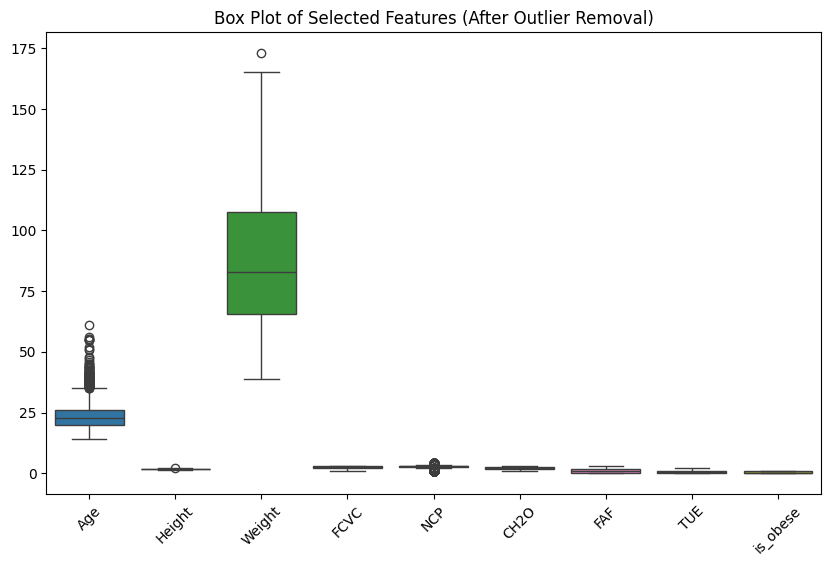

In [5]:
dataset = pd.read_csv('./ObesityDatasetEstimation.csv')
dataset = dataset.drop(columns=['Unnamed: 0'])
dataset.head(5)
dataset.isnull().sum()
print(dataset.shape)

# Assuming 'dataset' is your cleaned DataFrame
plt.figure(figsize=(10, 6))
sns.boxplot(data=dataset)
plt.xticks(rotation=45)
plt.title("Box Plot of Selected Features (After Outlier Removal)")
plt.show()



In [6]:
def identify_outliers(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify rows with outliers
        outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

        # Print the column name and outlier count
        print(f"{col}: {outlier_count} outliers")

identify_outliers(dataset)

# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# # Drop outliers from specific columns
# dataset = remove_outliers(dataset, 'Age')
# dataset = remove_outliers(dataset, 'Height')
# dataset = remove_outliers(dataset, 'Weight')
# dataset = remove_outliers(dataset, 'NCP')

# Check the shape of the DataFrame after removal


Age: 168 outliers
Height: 1 outliers
Weight: 1 outliers
FCVC: 0 outliers
NCP: 579 outliers
CH2O: 0 outliers
FAF: 0 outliers
TUE: 0 outliers
is_obese: 0 outliers


In [7]:
# Each Decision / Leaf Node:
class Node():
    def __init__(self, threshold=None, left=None, right=None, info_gain=None, value=None, feature_index=None):
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.feature_index = feature_index
        self.value = value


In [8]:
# Recursive Tree Builder
class DecisionTreeClassifier():
    def __init__(self, max_depth=2, min_samples_split=2,criterion="gini"):
        '''
          Sets The Stopping Conditions, initialises the Root to None
        '''
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.criterion = criterion

    def build_tree(self, X, Y, current_depth=0):
        '''
        Recursively Builds The Tree Based On Information Gain.

        This function splits the data and travers it building branches until
        either one of the stopping conditions has been met.

        Args:
          X (numpy array): Feature
          Y (numpy array): Target
          curr_depth (int): used to keep track of the tree depth.
        Returns:
          Node: A Node Object representing the current split. Either a subtree,
          or a leaf node.

        '''
        num_samples, num_features = X.shape

        if num_samples >= self.min_samples_split and current_depth <= self.max_depth:
            best_split = self.get_best_split(X, Y, num_features)

            if best_split["info_gain"] > 0:
                left_subtree = self.build_tree(best_split["dataset_left"][0], best_split["dataset_left"][1], current_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"][0], best_split["dataset_right"][1], current_depth + 1)

                return Node(feature_index=best_split["feature_index"], threshold=best_split["threshold"],
                            left=left_subtree, right=right_subtree, info_gain=best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)

    def get_best_split(self, X, Y, num_features):
        '''
        Finds the best feature and thresold to split the data by maximising
        information gain.

        This greedy function iterates through each feature, extracts all the
        unique  values, and calculates the information gain for each split.

        Args:
          X (numpy array): Feature
          Y (numpy array): Target
          num_features (int): Number of features in the dataset.

        Returns:
          A dictionary containing:
            - "feature_index": The Index Of The Best Feature To Split On.
            - "threshold": Threshold Value For That Feature For The Best Split.
            - "dataset_left": Data For The Left Child After The Split.
            - "dataset_right": Data For The Right Child After The Split.
            - "info_gain": The Information Gain From The Split.


        '''

        best_split = {}
        max_info_gain = -float('inf')

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)

            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(X, Y, feature_index, threshold)

                if len(dataset_left[0]) > 0 and len(dataset_right[0]) > 0:
                    left_y, right_y = dataset_left[1], dataset_right[1]

                    curr_info_gain = self.information_gain(Y, left_y, right_y)

                    if curr_info_gain > max_info_gain:
                        best_split = {"feature_index": feature_index, "threshold": threshold,
                                      "dataset_left": dataset_left, "dataset_right": dataset_right,
                                      "info_gain": curr_info_gain}
                        max_info_gain = curr_info_gain

        return best_split

    def split(self, X, Y, feature_index, threshold):
        '''
        Splits the Features and the Target Into 2 Sub Sets.

        Args:
          X (numpy array): The feature matrix
          Y (numpy array): The target matrix
          feature_index (int): The index of the feature to split on.
          threshold (float or int): The threshold value to split the feature data.

        Returns:
          tuple:
            - (X_left, Y_left): The subset where the X values are less than or equal to the threshold.
            - (X_right, Y_right): The subset where the X values are greater than the threshold.
        '''

        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask

        return (X[left_mask], Y[left_mask]), (X[right_mask], Y[right_mask])

    def information_gain(self, parent, l_child, r_child):
      '''
      Computes the information gain from splitting a node.

      This function calculates how much impurity (entropy or Gini index) is reduced
      when a parent node is split into two child nodes.

      Args:
        parent (numpy array): The target values of the parent node.
        l_child (numpy array): The target values of the left child node.
        r_child (numpy array): The target values of the right child node.
        mode (str): The impurity measure to use, either "entropy" or "gini".

      Returns:
        float: The information gain from the split.
      '''

      weight_l = len(l_child) / len(parent)
      weight_r = len(r_child) / len(parent)

      if self.criterion == "gini":
          gain = self.gini_impurity(parent) - (weight_l * self.gini_impurity(l_child) + weight_r * self.gini_impurity(r_child))
      else:
          gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))

      return gain

    def entropy(self, y):
        '''
          Calculates Entropy
        '''
        class_labels, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities))

    def gini_impurity(self, y):
        '''
          Calculates Gini Impurity
        '''
        class_labels, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def calculate_leaf_value(self, Y):
        '''
          Sets the value of the leaf node to be the most repeated class

          Args:
            Y (numpy array): target matrix

          Returns:
            argmax(Y's classes)
        '''
        return np.bincount(Y).argmax()

    def fit(self, X, Y):
      '''
      Builds the decision tree based on the provided features (X) and target (Y).

      Converts pandas DataFrame/Series to numpy arrays for faster processing.

      Args:
        X (numpy.ndarray or pandas.DataFrame): Features for training.
        Y (numpy.ndarray or pandas.Series): Target values for training.
      '''

      # Convert pandas DataFrame to numpy array
      X = X.values if hasattr(X, 'values') else X
      Y = Y.values if hasattr(Y, 'values') else Y
      self.root = self.build_tree(X, Y)

    def predict(self, X):
        '''
        Predicts the target values for a new set of features using the trained decision tree.

        Args:
          X (numpy or pandas array): Features for prediction.

        Returns:
          numpy array : Predicted target values.

        '''
        X = X.values if hasattr(X, 'values') else X  # Convert pandas DataFrame to numpy array
        return np.array([self._predict_sample(x, self.root) for x in X])

    def _predict_sample(self, sample, node):
      '''
      Recursively traverses the decision tree to predict the value for a single sample.

      Args:
        sample (numpy array or list): A single data point.
        node (Node): Current node in the decision tree.

      Returns:
        int or float: Predicted value for the sample.
      '''

      if node.value is not None:
          return node.value
      feature_value = sample[node.feature_index]
      if feature_value <= node.threshold:
          return self._predict_sample(sample, node.left)
      else:
          return self._predict_sample(sample, node.right)

    def get_params(self, deep=True):
      # To satisfy grid_search
      return {
          'max_depth': self.max_depth,
          'min_samples_split': self.min_samples_split,
          'criterion': self.criterion
      }
    def set_params(self, **params):
      # To satisfy grid_search
      for key, value in params.items():
        setattr(self, key, value)
      return self


In [9]:
from sklearn.model_selection import train_test_split

X = dataset.drop('is_obese', axis=1)
y = dataset['is_obese']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

print(f"yTrain set size: {len(y_train)}")
print(f"yTest set size: {len(y_test)}")


Train set size: 1688
Test set size: 423
yTrain set size: 1688
yTest set size: 423


In [10]:
classifier = DecisionTreeClassifier(max_depth=7,min_samples_split=2)
classifier.fit(X_train,y_train)


Accuracy: 99.29%


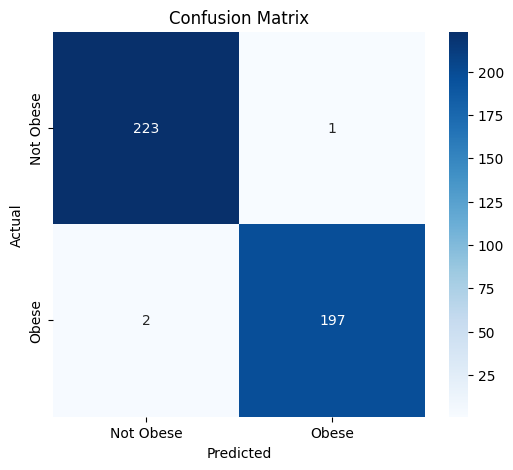

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       224
           1       0.99      0.99      0.99       199

    accuracy                           0.99       423
   macro avg       0.99      0.99      0.99       423
weighted avg       0.99      0.99      0.99       423



In [11]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Obese', 'Obese'], yticklabels=['Not Obese', 'Obese'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# print(df.corr(numeric_only=True)["is_obese"].sort_values(ascending=False))


In [12]:
# Hyper Paramter tuning with grid search
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'max_depth': [2, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'criterion': ['gini', 'entropy']
# }

# grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# # Fit the grid search
# grid_search.fit(X_train, y_train)

# # Get the best parameters and score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best cross-validation score: ", grid_search.best_score_)

# # Optionally, you can also print the results for all parameter combinations:
# print("All results: ", grid_search.cv_results_)

# Just Incase I Accidently Loose IT:
# Best parameters found:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
# Best cross-validation score:  0.9863624392042561
# All results:  {'mean_fit_time': array([ 9.43897262,  9.81018472,  9.24010124, 13.19865117, 12.99174562,
#        13.20916114, 13.0130702 , 13.49811883, 12.82795873, 13.632687  ,
#        13.12875371, 13.22381601,  9.72714133,  9.50135379,  9.99908509,
#        11.37669106, 11.24738007, 11.51418052, 11.38571339, 11.23015718,
#        11.68219838, 11.3500483 , 11.26748772, 11.04764371]), 'std_fit_time': array([1.16094709, 0.4881623 , 1.27637689, 1.62033764, 1.50354116,
#        0.85928045, 1.15715515, 0.75845023, 0.99086184, 0.93230223,
#        1.13383333, 1.06580971, 1.01140365, 1.22309339, 0.60820398,
#        0.86561917, 1.27868532, 1.17290967, 0.72100183, 0.97465946,
#        0.93007457, 0.66969442, 0.79245506, 1.38738592]), 'mean_score_time': array([0.00322218, 0.00322485, 0.00277696, 0.00365319, 0.00284324,
#        0.00418339, 0.00272374, 0.00290174, 0.00440197, 0.00296636,
#        0.00426955, 0.00371284, 0.00413942, 0.00316968, 0.00271955,
#        0.00531363, 0.00276856, 0.00278382, 0.00352168, 0.00416198,
#        0.0041923 , 0.00586371, 0.0058949 , 0.00338778]), 'std_score_time': array([2.85830981e-04, 3.78884256e-04, 2.35663711e-05, 1.52490491e-03,
#        2.02414122e-04, 2.71198725e-03, 6.62086978e-05, 6.40890073e-05,
#        2.07712394e-03, 2.20451900e-04, 1.88267168e-03, 1.57090100e-03,
#        2.79385886e-03, 7.62003781e-04, 2.09662246e-04, 3.05313653e-03,
#        1.00002700e-04, 5.83776837e-05, 1.67363091e-03, 2.82702178e-03,
#        2.43811614e-03, 3.41576752e-03, 3.85082239e-03, 1.70448857e-03]), 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini', 'gini',
#                    'gini', 'gini', 'gini', 'gini', 'gini', 'entropy',
#                    'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
#                    'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
#                    'entropy'],
#              mask=[False, False, False, False, False, False, False, False,
#                    False, False, False, False, False, False, False, False,
#                    False, False, False, False, False, False, False, False],
#        fill_value='?',
#             dtype=object), 'param_max_depth': masked_array(data=[2, 2, 2, 5, 5, 5, 10, 10, 10, 20, 20, 20, 2, 2, 2, 5,
#                    5, 5, 10, 10, 10, 20, 20, 20],
#              mask=[False, False, False, False, False, False, False, False,
#                    False, False, False, False, False, False, False, False,
#                    False, False, False, False, False, False, False, False],
#        fill_value=999999), 'param_min_samples_split': masked_array(data=[2, 5, 10, 2, 5, 10, 2, 5, 10, 2, 5, 10, 2, 5, 10, 2, 5,
#                    10, 2, 5, 10, 2, 5, 10],
#              mask=[False, False, False, False, False, False, False, False,
#                    False, False, False, False, False, False, False, False,
#                    False, False, False, False, False, False, False, False],
#        fill_value=999999), 'params': [{'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2}, {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 5}, {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 10}, {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}, {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5}, {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}, {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}, {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}, {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}, {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2}, {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 5}, {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 10}, {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 2}, {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 5}, {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 10}, {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}, {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}, {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10}, {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}, {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}, {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}, {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}, {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 5}, {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 10}], 'split0_test_score': array([0.9704142 , 0.9704142 , 0.9704142 , 0.97633136, 0.97633136,
#        0.98816568, 0.97633136, 0.97633136, 0.98816568, 0.97633136,
#        0.97633136, 0.98816568, 0.9704142 , 0.9704142 , 0.9704142 ,
#        0.99408284, 0.99408284, 0.99408284, 0.99408284, 0.99408284,
#        0.99408284, 0.99408284, 0.99408284, 0.99408284]), 'split1_test_score': array([0.99408284, 0.99408284, 0.99408284, 0.98816568, 0.98816568,
#        0.97928994, 0.9852071 , 0.98816568, 0.97928994, 0.9852071 ,
#        0.98816568, 0.97928994, 0.9852071 , 0.9852071 , 0.9852071 ,
#        0.99112426, 0.99112426, 0.99112426, 0.99408284, 0.99408284,
#        0.99112426, 0.99408284, 0.99408284, 0.99112426]), 'split2_test_score': array([0.96153846, 0.96153846, 0.96153846, 0.98816568, 0.9852071 ,
#        0.97928994, 0.98816568, 0.9852071 , 0.97928994, 0.98816568,
#        0.9852071 , 0.97928994, 0.96153846, 0.96153846, 0.96153846,
#        0.99112426, 0.98816568, 0.98224852, 0.99112426, 0.98816568,
#        0.98224852, 0.99112426, 0.98816568, 0.98224852]), 'split3_test_score': array([0.94065282, 0.94065282, 0.94065282, 0.97032641, 0.97032641,
#        0.97032641, 0.97032641, 0.97032641, 0.97032641, 0.97032641,
#        0.97032641, 0.97032641, 0.94362018, 0.94362018, 0.94362018,
#        0.97626113, 0.97626113, 0.97626113, 0.97626113, 0.97626113,
#        0.97626113, 0.97626113, 0.97626113, 0.97626113]), 'split4_test_score': array([0.94065282, 0.94065282, 0.94065282, 0.97329377, 0.97329377,
#        0.97329377, 0.97329377, 0.97329377, 0.97329377, 0.97329377,
#        0.97329377, 0.97329377, 0.94065282, 0.94065282, 0.94065282,
#        0.97626113, 0.97626113, 0.97626113, 0.97626113, 0.97626113,
#        0.97626113, 0.97626113, 0.97626113, 0.97626113]), 'mean_test_score': array([0.96146823, 0.96146823, 0.96146823, 0.97925658, 0.97866486,
#        0.97807315, 0.97866486, 0.97866486, 0.97807315, 0.97866486,
#        0.97866486, 0.97807315, 0.96028655, 0.96028655, 0.96028655,
#        0.98577072, 0.98517901, 0.98399558, 0.98636244, 0.98577072,
#        0.98399558, 0.98636244, 0.98577072, 0.98399558]), 'std_test_score': array([0.02005149, 0.02005149, 0.02005149, 0.00751803, 0.00688317,
#        0.00612658, 0.00688317, 0.00688317, 0.00612658, 0.00688317,
#        0.00688317, 0.00612658, 0.01666386, 0.01666386, 0.01666386,
#        0.00783935, 0.007518  , 0.00741979, 0.00831814, 0.00805957,
#        0.00741979, 0.00831814, 0.00805957, 0.00741979]), 'rank_test_score': array([19, 19, 19, 10, 11, 16, 11, 11, 16, 11, 11, 16, 22, 22, 22,  3,  6,
#         7,  1,  3,  7,  1,  3,  7], dtype=int32)}

Accuracy: 99.29%


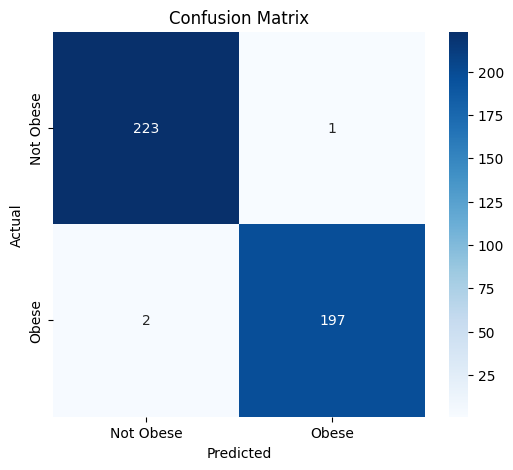

Cross-validation scores: [0.99115044 0.99115044 1.         1.         0.98230088 0.99115044
 1.         0.99115044 0.98214286 1.         0.96428571 0.99107143
 1.         0.99107143 0.97321429]
Mean accuracy: 98.99%
Standard deviation: 1.02%


In [13]:
# Testing With The Optimal Parameters:

from sklearn.model_selection import cross_val_score
classifier = DecisionTreeClassifier(max_depth=10,min_samples_split=2,criterion="entropy")
classifier.fit(X_train,y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Obese', 'Obese'], yticklabels=['Not Obese', 'Obese'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Cross-validate your classifier
cv_scores = cross_val_score(classifier, X_train, y_train, cv=15, scoring='accuracy')

# Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean() * 100:.2f}%")
print(f"Standard deviation: {cv_scores.std() * 100:.2f}%")


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load data
dataset = pd.read_csv('./ObesityDatasetEstimation.csv')
dataset = dataset.drop(columns=['Unnamed: 0'])

dataset = pd.get_dummies(dataset, drop_first=True)

X = dataset.drop(columns=['is_obese'])
y = dataset['is_obese']

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)

# KNN Accuracy
print("KNN Accuracy:", knn_accuracy)

# DECISION TREE
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)

# Decision Tree Accuracy
print("Decision Tree Accuracy:", dt_accuracy)

# LOGISTIC REGRESSION
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

# Logistic Regression Accuracy
print("Logistic Regression Accuracy:", lr_accuracy)

KNN Accuracy: 0.943217665615142
Decision Tree Accuracy: 0.9889589905362776
Logistic Regression Accuracy: 0.9952681388012619


In [15]:
from sklearn.model_selection import GridSearchCV

# KNN - Hyperparameter Optimization
knn_param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=15)
knn_grid.fit(X_train, y_train)

# KNN Best Model
knn_best = knn_grid.best_estimator_
knn_pred_best = knn_best.predict(X_test)
knn_accuracy_best = accuracy_score(y_test, knn_pred_best)

# Print KNN Results
# print("KNN Best Parameters:", knn_grid.best_params_)
print("KNN Accuracy (Optimized):", knn_accuracy_best)
# print("KNN Cross-Validation Scores:", knn_grid.cv_results_['mean_test_score'])
print("KNN Best Cross-Validation Score:", knn_grid.best_score_)
print("KNN Cross-Validation Standard Deviation:", knn_grid.cv_results_['std_test_score'].mean())

# DECISION TREE - Hyperparameter Optimization
dt_param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 5, 10, 20], 'min_samples_split': [2, 5, 10]}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_param_grid, cv=15)
dt_grid.fit(X_train, y_train)

# Decision Tree Best Model
dt_best = dt_grid.best_estimator_
dt_pred_best = dt_best.predict(X_test)
dt_accuracy_best = accuracy_score(y_test, dt_pred_best)

# Print Decision Tree Results
# print("Decision Tree Best Parameters:", dt_grid.best_params_)
print("Decision Tree Accuracy (Optimized):", dt_accuracy_best)
# print("Decision Tree Cross-Validation Scores:", dt_grid.cv_results_['mean_test_score'])
print("Decision Tree Best Cross-Validation Score:", dt_grid.best_score_)
print("Decision Tree Cross-Validation Standard Deviation:", dt_grid.cv_results_['std_test_score'].mean())

# LOGISTIC REGRESSION - Hyperparameter Optimization
lr_param_grid = {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
lr_grid = GridSearchCV(LogisticRegression(), lr_param_grid, cv=15)
lr_grid.fit(X_train, y_train)

# Logistic Regression Best Model
lr_best = lr_grid.best_estimator_
lr_pred_best = lr_best.predict(X_test)
lr_accuracy_best = accuracy_score(y_test, lr_pred_best)

# Print Logistic Regression Results
# print("Logistic Regression Best Parameters:", lr_grid.best_params_)
print("Logistic Regression Accuracy (Optimized):", lr_accuracy_best)
# print("Logistic Regression Cross-Validation Scores:", lr_grid.cv_results_['mean_test_score'])
print("Logistic Regression Best Cross-Validation Score:", lr_grid.best_score_)
print("Logistic Regression Cross-Validation Standard Deviation:", lr_grid.cv_results_['std_test_score'].mean())


KNN Accuracy (Optimized): 0.9589905362776026
KNN Best Cross-Validation Score: 0.9607160035731462
KNN Cross-Validation Standard Deviation: 0.023576834711998066
Decision Tree Accuracy (Optimized): 0.9921135646687698
Decision Tree Best Cross-Validation Score: 0.9925307496736069
Decision Tree Cross-Validation Standard Deviation: 0.014839219201263132
Logistic Regression Accuracy (Optimized): 0.9968454258675079
Logistic Regression Best Cross-Validation Score: 0.9952655809798667
Logistic Regression Cross-Validation Standard Deviation: 0.008423673986919155
